# Import Required Modules

In [1]:
!pip install gdown --quiet

In [1]:
import cv2
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from skimage.feature import local_binary_pattern, hog, haar_like_feature
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from skimage.transform import resize
from skimage.color import rgb2gray
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor
import joblib
import os
from PIL import Image
import seaborn as sns
import matplotlib.pyplot as plt
import zipfile
import csv
import gdown
import random
from collections import Counter

from matplotlib.colors import ListedColormap


# Download Data

In [ ]:
url = "https://drive.google.com/file/d/1Mr5asNANkbLVtQdcnZiQXmRpH3jJUyhT/view?usp=drive_link"
output = "emotion_data.zip"
gdown.download(url=url, output=output, fuzzy=True)

with zipfile.ZipFile(output, 'r') as zip_ref:
    zip_ref.extractall('..\data')

os.remove(output)

# Make Data Annotation

In [2]:
data_dir = "..\data"

labels = ["angry", "disgust", "fear", "happy", "neutral", "sad", "surprise"]

def create_csv(data_type, labels):
    csv_file_path = os.path.join(data_dir, f"{data_type}.csv")
    data_rows = []

    for label in labels:
        label_dir = os.path.join(data_dir, data_type, label)
        for filename in os.listdir(label_dir):
            if filename.endswith(".jpg"):
                image_path = os.path.join(label_dir, filename)
                data_rows.append([image_path, label])

    random.shuffle(data_rows)

    with open(csv_file_path, "w", newline="") as file:
        writer = csv.writer(file)
        writer.writerow(["image_path", "label"])
        writer.writerows(data_rows)

create_csv("train", labels)
create_csv("test", labels)

print("Done!")

Done!


# Load Data

In [3]:
# Load CSV data
data_train = pd.read_csv('..\\data\\train.csv')
data_train.head()
# image_paths = data_train['image_path'].tolist()
# labels = data_train['label'].tolist()

# # Encode labels
# label_encoder = LabelEncoder()
# encoded_labels = label_encoder.fit_transform(labels)

,image_path,label
0,..\data\train\happy\Training_70273171.jpg,happy
1,..\data\train\neutral\Training_39384303.jpg,neutral
2,..\data\train\happy\Training_99243830.jpg,happy
3,..\data\train\surprise\Training_30791149.jpg,surprise
4,..\data\train\surprise\Training_17280918.jpg,surprise


In [4]:
# 1. Drop 'disgust' Class
data_train_filtered = data_train[data_train['label'] != 'disgust'].copy()

# 2. Sample Each Class
sampled_data = pd.DataFrame()
target_sample_size = 3000

for label in data_train_filtered['label'].unique():
    class_samples = data_train_filtered[data_train_filtered['label'] == label]
    
    if len(class_samples) > target_sample_size:
        sampled_class = class_samples.sample(n=target_sample_size, random_state=42) 
    else:  # In case a class has fewer samples
        sampled_class = class_samples

    sampled_data = pd.concat([sampled_data, sampled_class])

# 3. Extract Image Paths and Labels
image_paths = sampled_data['image_path'].tolist()
labels = sampled_data['label'].tolist()

In [5]:
# Encode labels
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)

# Define Functions for Preprocessing and Feature Extraction

In [6]:
def detect_face(image):
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))
    if len(faces) == 0:
        return None
    x, y, w, h = faces[0]
    return gray[y:y+h, x:x+w]

def align_face(face):
    eye_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_eye.xml')
    eyes = eye_cascade.detectMultiScale(face)
    if len(eyes) >= 2:
        eyes = sorted(eyes, key=lambda x: x[2]*x[3], reverse=True)[:2]
        eye_center = np.array([[(ex+ew//2), (ey+eh//2)] for (ex, ey, ew, eh) in eyes])
        dY = eye_center[1][1] - eye_center[0][1]
        dX = eye_center[1][0] - eye_center[0][0]
        angle = np.degrees(np.arctan2(dY, dX)) - 180
        center = tuple(np.mean(eye_center, axis=0).astype(int))
        try:
            M = cv2.getRotationMatrix2D(center, angle, scale=1.0)
            aligned_face = cv2.warpAffine(face, M, (face.shape[1], face.shape[0]), flags=cv2.INTER_CUBIC)
            return aligned_face
        except:
            return cv2.resize(face, (48, 48))
    else:
        return cv2.resize(face, (48, 48))

def normalize_image(image):
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    return clahe.apply(image)

def calculate_haar_features(image):
    integral_image = cv2.integral(image)
    features = []
    for size in [16, 24, 32]:
        resized_img = resize(integral_image, (size, size))
        feature_types = ['type-2-x', 'type-2-y', 'type-3-x', 'type-3-y']
        haar_features = haar_like_feature(resized_img, 0, 0, size, size, feature_types)
        features.extend(haar_features)
    return features

def calculate_lbp_features(image):
    lbp = local_binary_pattern(image, P=8, R=1, method='uniform')
    (hist, _) = np.histogram(lbp.ravel(), bins=np.arange(0, 59))
    hist = hist.astype('float')
    hist /= (hist.sum() + 1e-7)
    return hist

def calculate_hog_features(image):
    fd = hog(image, orientations=8, pixels_per_cell=(16, 16), cells_per_block=(1, 1), visualize=False)
    return fd

def extract_features(image_path):
    image = cv2.imread(image_path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    features = []
    features.extend(calculate_lbp_features(gray))
    features.extend(calculate_hog_features(gray))
    return features

# Optimize Feature Extraction for Train set

In [7]:
def process_image(image_path):
    return extract_features(image_path)

with ThreadPoolExecutor(max_workers=12) as executor:
    features = list(tqdm(executor.map(process_image, image_paths), total=len(image_paths)))

# Remove None results (images where no face was detected)
filtered_features = [f for f in features if f is not None]
filtered_labels = [encoded_labels[i] for i, f in enumerate(features) if f is not None]

# Convert to numpy arrays
X = np.array(filtered_features)
y = np.array(filtered_labels)

100%|██████████| 18000/18000 [00:19<00:00, 911.82it/s]


In [8]:
X.shape, y.shape

((18000, 130), (18000,))

In [9]:
label_counts = Counter(y)
print("Labels Count")
for label, count in label_counts.items():
    print(f"  Label {label}: {count} Sample")

Labels Count
  Label 2: 3000 Sample
  Label 3: 3000 Sample
  Label 5: 3000 Sample
  Label 0: 3000 Sample
  Label 4: 3000 Sample
  Label 1: 3000 Sample


# Visualize Train Features

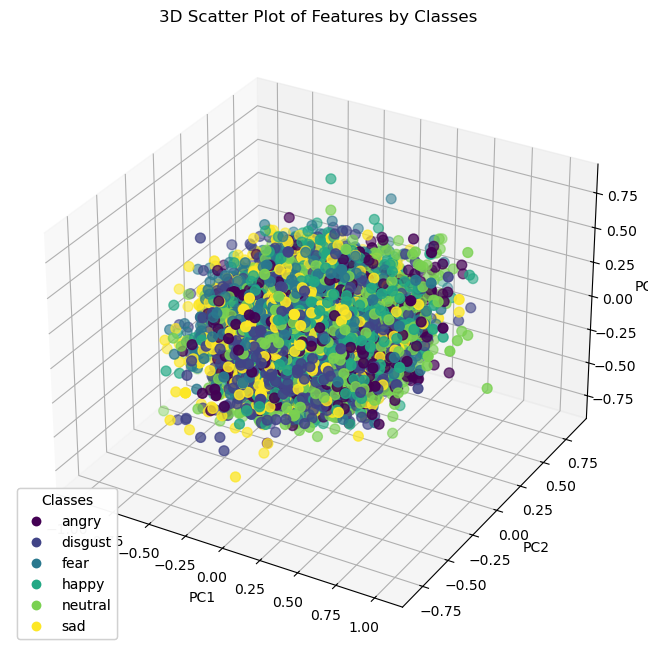

In [10]:
classes = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X)

# Create 3D scatter plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], c=y, cmap='viridis', s=50)

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.set_title('3D Scatter Plot of Features by Classes')

legend1 = ax.legend(*(scatter.legend_elements()[0],classes),
                    loc="lower left", title="Classes")
ax.add_artist(legend1)

plt.show()

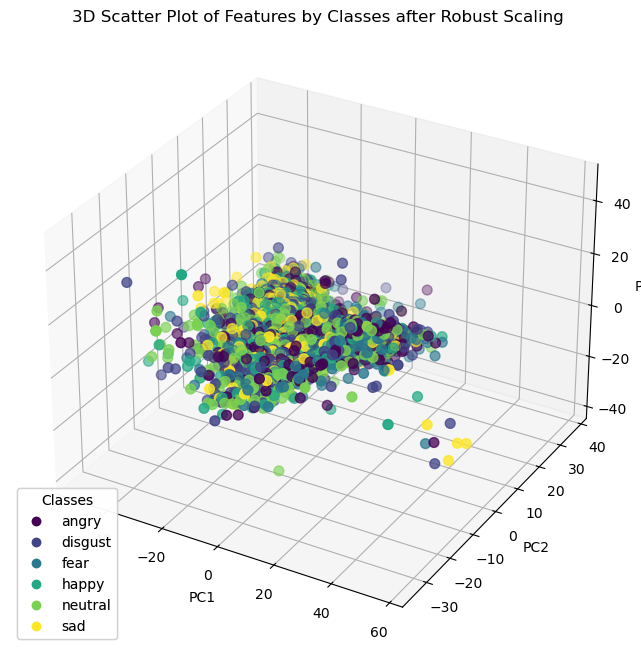

In [11]:
trans_X = RobustScaler().fit_transform(X)

pca = PCA(n_components=3)
X_pca = pca.fit_transform(trans_X)

# Create 3D scatter plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], c=y, cmap='viridis', s=50)

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.set_title('3D Scatter Plot of Features by Classes after Robust Scaling')

legend1 = ax.legend(*(scatter.legend_elements()[0],classes),
                    loc="lower left", title="Classes")
ax.add_artist(legend1)

plt.show()

In [12]:
X_train = trans_X
y_train = y

(X_train.shape, y_train.shape)

((18000, 130), (18000,))

# Extract Test Set and Visualize

100%|██████████| 7067/7067 [00:03<00:00, 1823.56it/s]


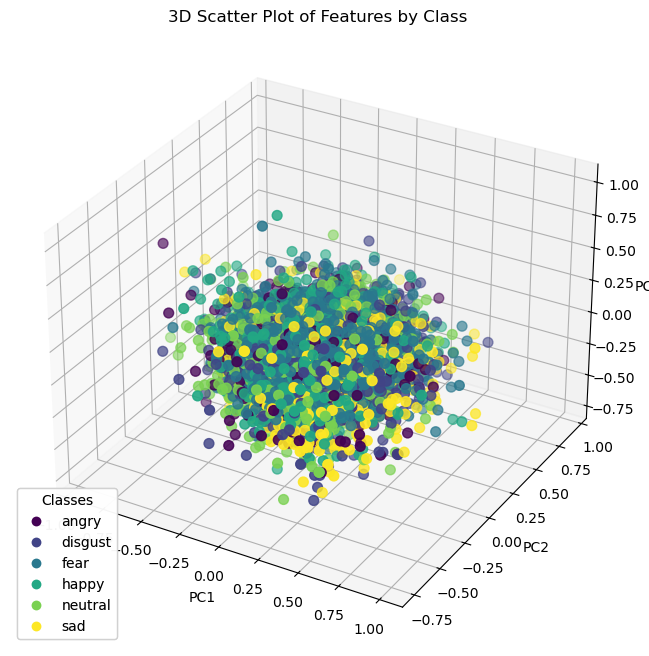

In [13]:
data_test = pd.read_csv('..\\data\\test.csv')

# 1. Drop 'disgust' Class
data_test_filtered = data_test[data_test['label'] != 'disgust'].copy()

# 2. Sample Each Class
sampled_data = pd.DataFrame()
target_sample_size = 3000

for label in data_test_filtered['label'].unique():
    class_samples = data_test_filtered[data_test_filtered['label'] == label]
    
    if len(class_samples) > target_sample_size:
        sampled_class = class_samples.sample(n=target_sample_size, random_state=42) 
    else:  # In case a class has fewer samples
        sampled_class = class_samples

    sampled_data = pd.concat([sampled_data, sampled_class])

# 3. Extract Image Paths and Labels
image_paths_test = sampled_data['image_path'].tolist()
labels_test = sampled_data['label'].tolist()
encoded_labels_test = label_encoder.transform(labels_test)


with ThreadPoolExecutor(max_workers=12) as executor:
    features = list(tqdm(executor.map(process_image, image_paths_test), total=len(image_paths_test)))

filtered_features = [f for f in features if f is not None]
filtered_labels = [encoded_labels_test[i] for i, f in enumerate(features) if f is not None]

# Convert to numpy arrays
X_test = np.array(filtered_features)
y_test = np.array(filtered_labels)

classes = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_test)

# Create 3D scatter plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], c=y_test, cmap='viridis', s=50)

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.set_title('3D Scatter Plot of Features by Class')

legend1 = ax.legend(*(scatter.legend_elements()[0],classes),
                    loc="lower left", title="Classes")
ax.add_artist(legend1)

plt.show()

In [14]:
X_test = RobustScaler().fit_transform(X_test)
y_test = encoded_labels_test

X_test.shape, y_test.shape

((7067, 130), (7067,))

# Train and Evaluate

In [15]:
'''
Labels Count
  Label 3: 3000 Sample
  Label 5: 3000 Sample
  Label 2: 3000 Sample
  Label 4: 3000 Sample
  Label 0: 3000 Sample
  Label 1: 3000 Sample
'''

'\nLabels Count\n  Label 3: 3000 Sample\n  Label 5: 3000 Sample\n  Label 2: 3000 Sample\n  Label 4: 3000 Sample\n  Label 0: 3000 Sample\n  Label 1: 3000 Sample\n'

In [16]:
# from imblearn.over_sampling import SMOTE
# from imblearn.under_sampling import RandomUnderSampler
# from imblearn.pipeline import Pipeline

# sampling_strategy_over = {i: 8000 for i in range(7)}
# sampling_strategy_under = {i: 3000 for i in range(7)}

# over = SMOTE(sampling_strategy=sampling_strategy_over)
# under = RandomUnderSampler(sampling_strategy=sampling_strategy_under)
# steps = [('o', over), ('u', under)]
# pipeline = Pipeline(steps=steps)
# X_train_resampled, y_train_resampled = pipeline.fit_resample(X_train, y_train)

In [24]:
# Define models 
svc = SVC(kernel='rbf', probability=True, random_state=42, verbose=False)

rf = RandomForestClassifier(n_estimators=80, random_state=42, n_jobs=-1, verbose=False)

sgd = SGDClassifier(loss='hinge', random_state=42, n_jobs=-1, verbose=False)

mlp = MLPClassifier(hidden_layer_sizes=(192,),  # Adjust these parameters
                    activation='relu',
                    solver='adam',
                    learning_rate='adaptive',
                    max_iter=1000,
                    random_state=42,
                    tol=1e-4,
                    verbose=True)

**Random Forest Classifier**

Training Random Forest Classifier...
Save model
Evaluation
Accuracy Random Forest: 0.35


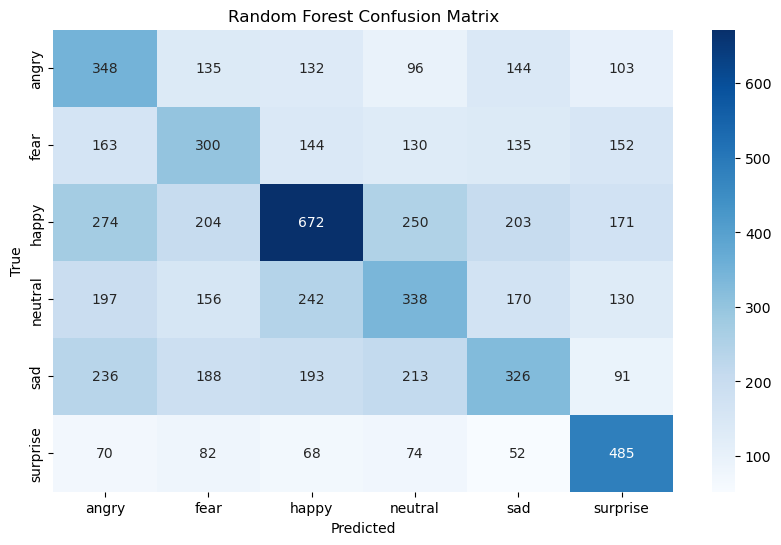

In [25]:
print("Training Random Forest Classifier...")
rf.fit(X_train, y_train)
print("Save model")
joblib.dump(rf, '..\\pretrained\\emotion_recognition_rf_model.pkl')

print("Evaluation")
y_pred_rf = rf.predict(X_test)

accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f"Accuracy Random Forest: {accuracy_rf:.2f}")

conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)

plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix_rf, annot=True, fmt='d', cmap='Blues', 
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Random Forest Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

Training SGDClassifier...
Save model
Evaluation
Accuracy SGD: 0.25


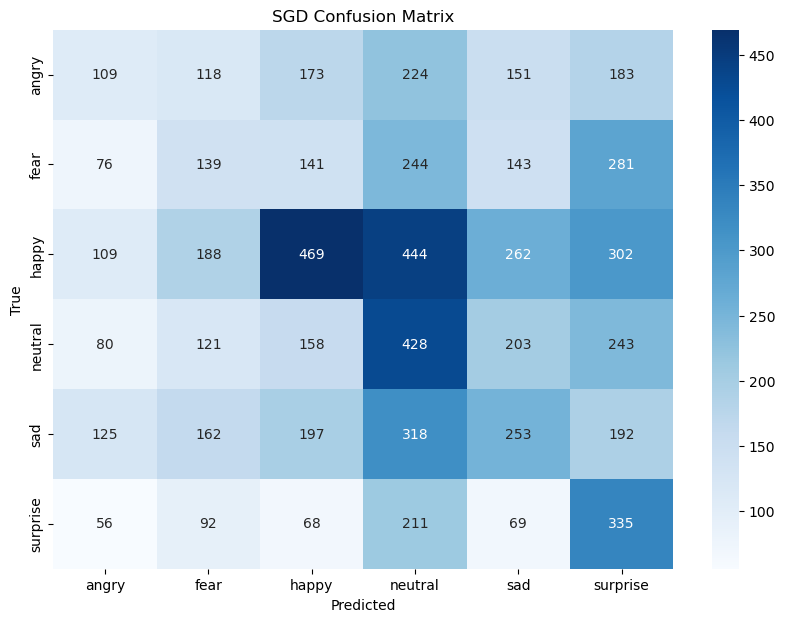

In [26]:
print("Training SGDClassifier...")
with joblib.parallel_backend('threading', n_jobs=-1):
    sgd.fit(X_train, y_train)

print("Save model")
joblib.dump(sgd, '..\\pretrained\\emotion_recognition_sgd_model.pkl')

print("Evaluation")
y_pred_sgd = sgd.predict(X_test)
accuracy_sgd = accuracy_score(y_test, y_pred_sgd)
print(f"Accuracy SGD: {accuracy_sgd:.2f}")

conf_matrix_sgd = confusion_matrix(y_test, y_pred_sgd)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix_sgd, annot=True, fmt='d', cmap='Blues', 
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('SGD Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [87]:
print("Training SVC...")
with joblib.parallel_backend('threading', n_jobs=-1):
    svc.fit(X_train, y_train)
print("Save model")
joblib.dump(svc, '..\\pretrained\\emotion_recognition_svc_model.pkl')

print("Evaluation")
y_pred_svc = svc.predict(X_test)
accuracy_svc = accuracy_score(y_test, y_pred_svc)
print(f"Accuracy SVC: {accuracy_svc:.2f}")


conf_matrix_svc = confusion_matrix(y_test, y_pred_svc)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix_svc, annot=True, fmt='d', cmap='Blues', 
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('SVC Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

Training SVC...


Training MLP Classifier...
Iteration 1, loss = 1.79306316
Iteration 2, loss = 1.66069537
Iteration 3, loss = 1.61580081
Iteration 4, loss = 1.58452286
Iteration 5, loss = 1.56013141
Iteration 6, loss = 1.53918555
Iteration 7, loss = 1.52082214
Iteration 8, loss = 1.50424997
Iteration 9, loss = 1.48773727
Iteration 10, loss = 1.47381031
Iteration 11, loss = 1.45934304
Iteration 12, loss = 1.44471791
Iteration 13, loss = 1.43302572
Iteration 14, loss = 1.41938215
Iteration 15, loss = 1.40682685
Iteration 16, loss = 1.39490009
Iteration 17, loss = 1.38451060
Iteration 18, loss = 1.37500856
Iteration 19, loss = 1.36347947
Iteration 20, loss = 1.35471262
Iteration 21, loss = 1.34475123
Iteration 22, loss = 1.33339882
Iteration 23, loss = 1.32508839
Iteration 24, loss = 1.31815113
Iteration 25, loss = 1.30728897
Iteration 26, loss = 1.29764471
Iteration 27, loss = 1.29010919
Iteration 28, loss = 1.28177796
Iteration 29, loss = 1.27255304
Iteration 30, loss = 1.26694360
Iteration 31, loss = 1

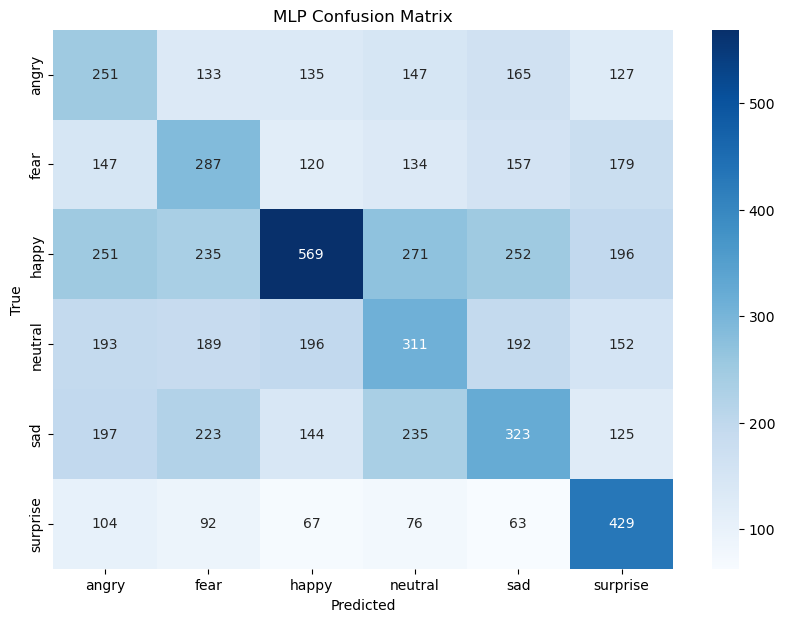

In [27]:
print("Training MLP Classifier...")
with joblib.parallel_backend('threading', n_jobs=-1):
    mlp.fit(X_train, y_train)
    
print("Save model")
joblib.dump(mlp, '..\\pretrained\\emotion_recognition_mlp_model.pkl')

print("Evaluation")
y_pred_mlp = mlp.predict(X_test)
accuracy_mlp = accuracy_score(y_test, y_pred_mlp)
print(f"Accuracy MLP: {accuracy_mlp:.2f}")

conf_matrix_mlp = confusion_matrix(y_test, y_pred_mlp)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix_mlp, annot=True, fmt='d', cmap='Blues', 
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('MLP Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Display Decision Boundary Box

In [28]:
correct_indices = np.where(y_pred_mlp == y_test)[0]
X_test_correct = X_test[correct_indices]
y_test_correct = y_test[correct_indices]

X_test_correct.shape, y_test_correct.shape

((2170, 130), (2170,))

In [29]:
def plot_decision_boundary(model, X, y, n_components=2, h=0.02, title="Decision Boundary" , label_encoder=None):
    # Reduce to n_components dimensions using PCA
    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(X)
    
    # Create a mesh grid
    x_min, x_max = X_pca[:, 0].min() - 1, X_pca[:, 0].max() + 1
    y_min, y_max = X_pca[:, 1].min() - 1, X_pca[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    
    # Predict on mesh grid
    Z = model.predict(pca.inverse_transform(np.c_[xx.ravel(), yy.ravel()]))
    Z = Z.reshape(xx.shape)
    
    # Plot the decision boundary
    plt.figure(figsize=(10, 7))
    plt.contourf(xx, yy, Z, alpha=0.8, cmap=ListedColormap(('red', 'blue', 'green', 'purple', 'yellow', 'cyan', 'magenta')))
    
    # Plot training points
    scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, edgecolor='k', s=20, cmap=ListedColormap(('red', 'blue', 'green', 'purple', 'yellow', 'cyan', 'magenta')))
    plt.title(title)
    plt.xlabel("PCA Component 1")
    plt.ylabel("PCA Component 2")
    ax.legend(*(scatter.legend_elements()[0],classes),
                    loc="lower left", title="Classes")
    plt.show()

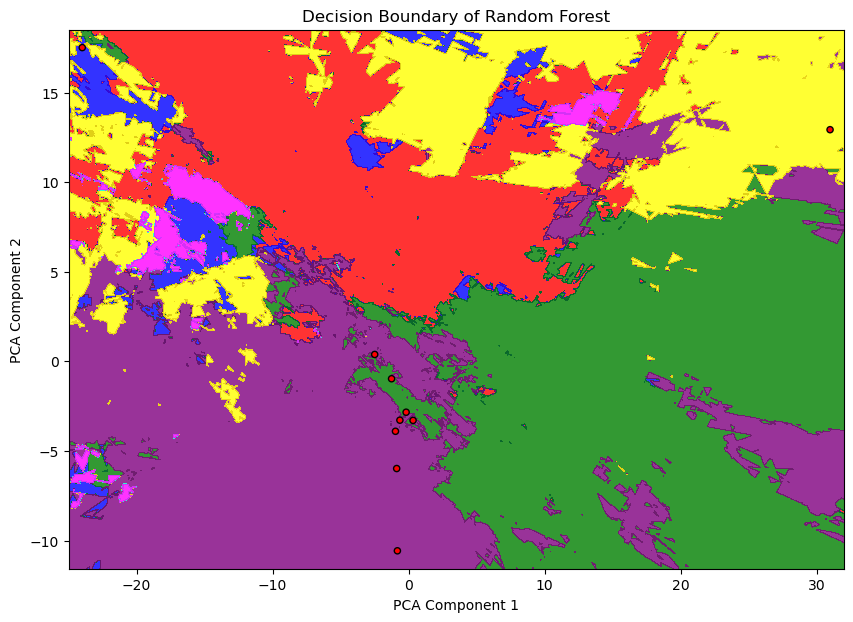

In [37]:
plot_decision_boundary(rf, X_test_correct[100:110], y_test_correct[100:110], title="Decision Boundary of Random Forest",  label_encoder=label_encoder)

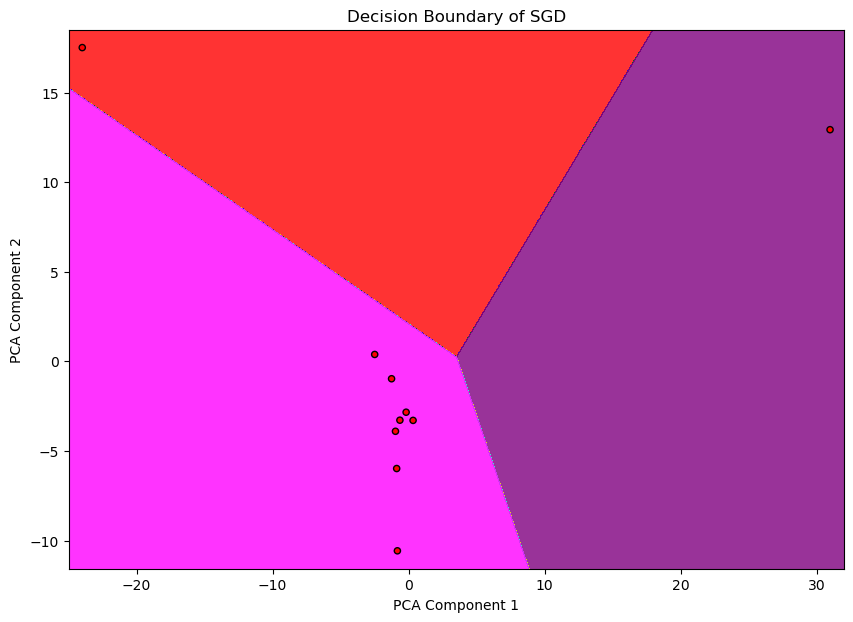

In [38]:
plot_decision_boundary(sgd, X_test_correct[100:110], y_test_correct[100:110], title="Decision Boundary of SGD",  label_encoder=label_encoder)

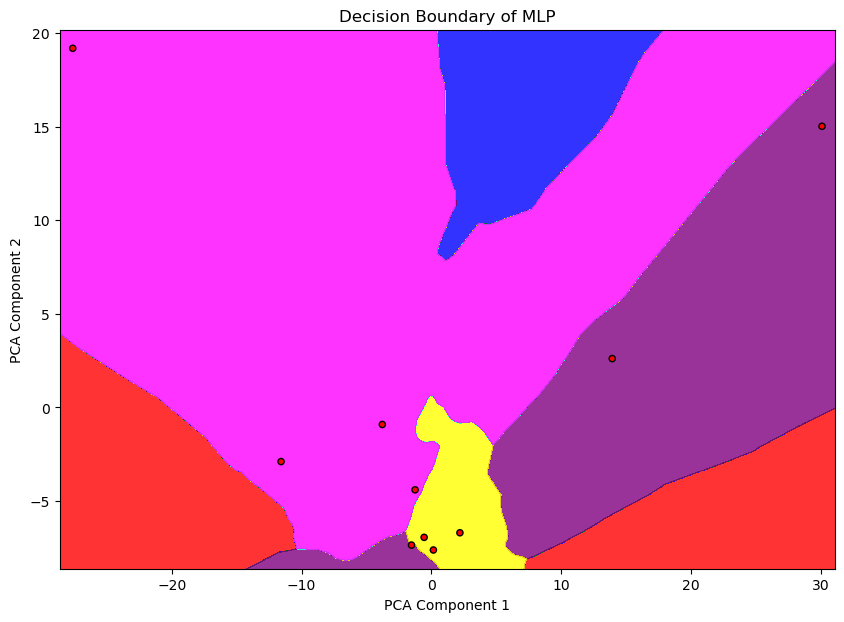

In [72]:
plot_decision_boundary(mlp, X_test_correct[0:10], y_test_correct[0:10], title="Decision Boundary of MLP",  label_encoder=label_encoder)

# Display Results

In [40]:
def display(image_path, emotion_label):
    image = Image.open(image_path)
    plt.imshow(image)
    plt.title(f'Predicted Emotion: {emotion_label}')
    plt.axis('off')
    plt.show()

In [ ]:
sample_image_path = image_paths[310]
sample_features = extract_features(sample_image_path)
predicted_label = rf.predict(np.array([sample_features]))[0]
predicted_emotion = label_encoder.inverse_transform([predicted_label])[0]
display(sample_image_path, predicted_emotion)
print(sample_image_path)